# **Deep Learning Course**

## **Loss Functions and Multilayer Perceptrons (MLP)**

---

### **Student Information:**

- **Name:** *Mohammad Morsali*
- **Student Number:** *400101956*

---

### **Assignment Overview**

In this notebook, we will explore various loss functions used in neural networks, with a specific focus on their role in training **Multilayer Perceptrons (MLPs)**. By the end of this notebook, you will have a deeper understanding of:
- Types of loss functions
- How loss functions affect the training process
- The relationship between loss functions and model optimization in MLPs

---

### **Table of Contents**

1. Introduction to Loss Functions
2. Types of Loss Functions
3. Multilayer Perceptrons (MLP)
4. Implementing Loss Functions in MLP
5. Conclusion

---



# 1.Introduction to Loss Functions 

In deep learning, **loss functions** play a crucial role in training models by quantifying the difference between the predicted outputs and the actual targets. Selecting the appropriate loss function is essential for the success of your model. In this assay, we will explore various loss functions available in PyTorch, understand their theoretical backgrounds, and provide you with a scaffolded class to experiment with these loss functions.

Before begining, let's train a simle MLP model using the **L1Loss** function. We'll return to this model later to experiment with different loss functions. We'll start by importing the necessary libraries and defining the model architecture.

First things first, let's talk about **L1Loss**.

### 1. L1Loss (`torch.nn.L1Loss`)
- **Description:** Also known as Mean Absolute Error (MAE), L1Loss computes the average absolute difference between the predicted values and the target values.
- **Use Case:** Suitable for regression tasks where robustness to outliers is desired.

Here is the mathematical formulation of L1Loss:
\begin{equation}
\text{L1Loss} = \frac{1}{n} \sum_{i=1}^{n} |y_{\text{pred}_i} - y_{\text{true}_i}|
\end{equation}

Let's implement a simple MLP model using the L1Loss function.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader,random_split
from sklearn.model_selection import train_test_split
from torch.optim import Adam
import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from torch.optim.lr_scheduler import StepLR
import requests
from io import StringIO
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import numpy as np
# Don't be courious about Adam, it's just a fancy name for a fancy optimization algorithm

Here, we'll define a class called `SimpleMLP` that inherits from `nn.Module`. This class can have multiple layers, and we'll use the `nn.Sequential` module to define the layers of the model. The model will have the following architecture:

In [19]:
class SimpleMLP(nn.Module):
    def __init__(
        self, 
        input_dim, 
        hidden_dim, 
        output_dim, 
        num_hidden_layers=1, 
        last_layer_activation_fn=nn.ReLU
    ):
        super(SimpleMLP, self).__init__()

        # Initialize a list to store layers
        net_layers = []

        # Add the input layer with activation
        net_layers.append(nn.Linear(input_dim, hidden_dim))
        net_layers.append(nn.ReLU())

        # Add specified number of hidden layers with activation
        for layer_num in range(1, num_hidden_layers):
            net_layers.append(nn.Linear(hidden_dim, hidden_dim))
            net_layers.append(nn.ReLU())

        # Add the output layer
        net_layers.append(nn.Linear(hidden_dim, output_dim))

        # Optionally add activation function to the output layer
        if last_layer_activation_fn is not None:
            net_layers.append(last_layer_activation_fn())

        # Create the model using nn.Sequential
        self.model = nn.Sequential(*net_layers)

        # Initialize weights
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize weights for linear layers using Kaiming uniform initialization
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x):
        # Forward pass through the model
        return self.model(x)


Now, let's define a class called `SimpleMLP_Loss` that has the following architecture:

In [20]:
class SimpleMLPTrainer:
    def __init__(
        self, 
        model, 
        criterion, 
        optimizer, 
        scheduler=None, 
        save_model=False, 
        checkpoint_path='model_checkpoint.pth', 
        writer=None
    ):
        """
        Initialize the trainer with model, criterion, optimizer, and optional scheduler and writer.

        Args:
            model: The neural network model to train.
            criterion: Loss function.
            optimizer: Optimization algorithm.
            scheduler: Learning rate scheduler (optional).
            save_model: Whether to save the model when validation loss improves.
            checkpoint_path: Path to save the model checkpoint.
            writer: TensorBoard SummaryWriter for logging (optional).
        """
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.save_model = save_model
        self.checkpoint_path = checkpoint_path
        self.best_loss = float('inf')
        self.writer = writer

    def train(self, train_loader, num_epochs, val_loader=None):
        """
        Train the model using the provided data loader.

        Args:
            train_loader: DataLoader for training data.
            num_epochs: Number of epochs to train.
            val_loader: DataLoader for validation data (optional).

        Returns:
            Tuple of lists containing training losses, validation losses, and validation accuracies.
        """
        self.model.train()
        epoch_losses = []
        validation_losses = []
        validation_accuracies = []

        for epoch_idx in range(num_epochs):
            running_loss = 0.0
            for batch_inputs, batch_targets in tqdm(
                train_loader, desc=f"Epoch {epoch_idx+1}/{num_epochs}"
            ):
                self.optimizer.zero_grad()
                
                # Forward pass
                predictions = self.model(batch_inputs)
                loss = self.criterion(predictions, batch_targets)
                
                # Backward pass and optimization
                loss.backward()
                self.optimizer.step()
                
                running_loss += loss.item()

            # Calculate average loss for the epoch
            avg_loss = running_loss / len(train_loader)
            epoch_losses.append(avg_loss)
            
            print(f"Epoch [{epoch_idx+1}/{num_epochs}], Loss: {avg_loss:.4f}")

            # Step the scheduler if it's provided
            if self.scheduler:
                self.scheduler.step()

            # Evaluate on validation set if provided
            if val_loader is not None:
                val_loss, val_accuracy = self.evaluate(val_loader, current_epoch=epoch_idx)
                validation_losses.append(val_loss)
                validation_accuracies.append(val_accuracy)

                # Log validation metrics
                if self.writer:
                    self.writer.add_scalar('Loss/validation', val_loss, epoch_idx)
                    self.writer.add_scalar('Accuracy/validation', val_accuracy, epoch_idx)

            # Log training loss
            if self.writer:
                self.writer.add_scalar('Loss/train', avg_loss, epoch_idx)

            # Save model checkpoint if loss improves
            if avg_loss < self.best_loss and self.save_model:
                self.best_loss = avg_loss
                torch.save(self.model.state_dict(), self.checkpoint_path)
                print(f"Model saved with loss {avg_loss:.4f}")

        return epoch_losses, validation_losses, validation_accuracies

    def evaluate(self, val_loader, current_epoch=0):
        """
        Evaluate the model on the validation set.

        Args:
            val_loader: DataLoader for validation data.
            current_epoch: The current epoch number (used for logging).

        Returns:
            Tuple containing average validation loss and accuracy.
        """
        self.model.eval()
        total_val_loss = 0.0
        total_correct = 0
        total_samples = 0

        with torch.no_grad():
            for batch_inputs, batch_targets in val_loader:
                predictions = self.model(batch_inputs)
                loss = self.criterion(predictions, batch_targets)
                total_val_loss += loss.item()

                # Determine if it's binary or multi-class classification
                if predictions.dim() == 1 or predictions.shape[1] == 1:
                    # Binary classification
                    predicted_labels = (predictions >= 0.5).float().squeeze()
                    batch_targets = batch_targets.squeeze()
                else:
                    # Multi-class classification
                    predicted_labels = torch.argmax(predictions, dim=1)
                    batch_targets = batch_targets.squeeze()
                    if batch_targets.dim() > 1:
                        batch_targets = torch.argmax(batch_targets, dim=1)

                total_correct += (predicted_labels == batch_targets).sum().item()
                total_samples += batch_targets.size(0)

        avg_val_loss = total_val_loss / len(val_loader)
        accuracy = 100 * total_correct / total_samples if total_samples > 0 else 0

        print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")

        # Log validation metrics
        if self.writer:
            self.writer.add_scalar('Loss/validation', avg_val_loss, current_epoch)
            self.writer.add_scalar('Accuracy/validation', accuracy, current_epoch)

        return avg_val_loss, accuracy


Next, lets test our model using the L1Loss function. You'll use <span style="color:red">*Titanic Dataset*</span> to train the model.


In [ ]:


train_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
response = requests.get(train_url, verify=False)
data = pd.read_csv(StringIO(response.text))
data = data[['Pclass', 'Sex', 'Age', 'Fare', 'Survived']].dropna()
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

# Extract input features and target labels
feature_values = data[['Pclass', 'Sex', 'Age', 'Fare']].values
label_values = data['Survived'].values

# Scale features using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_values)

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(scaled_features, dtype=torch.float32)
y_tensor = torch.tensor(label_values, dtype=torch.float32).view(-1, 1)

# Create a TensorDataset from tensors
dataset = TensorDataset(X_tensor, y_tensor)

# Calculate sizes for training and validation datasets
train_dataset_size = int(0.8 * len(dataset))
val_dataset_size = len(dataset) - train_dataset_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(
    dataset, [train_dataset_size, val_dataset_size]
)

# Handle class imbalance using WeightedRandomSampler
from torch.utils.data import WeightedRandomSampler

# Calculate class counts and weights
class_counts = np.bincount(label_values.astype(int))
class_weights = 1. / class_counts
sample_weights = class_weights[label_values.astype(int)]

# Create a WeightedRandomSampler
weighted_sampler = WeightedRandomSampler(
    weights=sample_weights, num_samples=len(sample_weights), replacement=True
)

# Create DataLoaders for training and validation
train_loader = DataLoader(
    train_dataset, batch_size=32, sampler=weighted_sampler
)
val_loader = DataLoader(
    val_dataset, batch_size=32, shuffle=False
)


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<div style="text-align: center;"> <span style="color:red; font-size: 26px; font-weight: bold;">Let's train!</span> </div>

In [ ]:
# Using L1 Loss for training the model on the Titanic dataset with improvements


# Define model parameters
input_dim = feature_values.shape[1]  # Number of input features from the dataset
hidden_dim = 16                      # Number of neurons in each hidden layer
output_dim = 1                       # Output dimension for binary classification (Survived or not)
num_hidden_layers = 2                # Total number of hidden layers in the model

# Instantiate the SimpleMLP model
model = SimpleMLP(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_hidden_layers=num_hidden_layers,
    last_layer_activation_fn=nn.Sigmoid  # Use Sigmoid activation for binary classification
)

# Define the loss function using Mean Absolute Error (L1 Loss)
criterion = nn.L1Loss()

# Define the optimizer (Adam optimizer with a learning rate of 0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define a learning rate scheduler to adjust the learning rate during training
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Instantiate the SimpleMLPTrainer with the model, loss function, optimizer, and scheduler
trainer = SimpleMLPTrainer(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    save_model=True,                   # Save the model when validation loss improves
    checkpoint_path='best_model.pth'   # Path to save the best model
)

# Set the number of epochs for training
num_epochs = 50

# Implement early stopping parameters
early_stopping_patience = 5  # Stop training if validation loss doesn't improve for 5 consecutive epochs
best_val_loss = float('inf')
epochs_without_improvement = 0

# Lists to store training and validation metrics
training_losses = []
validation_losses = []
validation_accuracies = []
validation_precisions = []
validation_recalls = []
validation_f1s = []

# Training loop with early stopping and metric tracking
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_training_loss = running_loss / len(train_loader)
    training_losses.append(avg_training_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Collect targets and predictions for metrics
            predicted = (outputs >= 0.5).float().squeeze()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    validation_losses.append(avg_val_loss)

    # Calculate additional metrics
    accuracy = (np.array(all_predictions) == np.array(all_targets)).mean() * 100
    precision = precision_score(all_targets, all_predictions)
    recall = recall_score(all_targets, all_predictions)
    f1 = f1_score(all_targets, all_predictions)
    validation_accuracies.append(accuracy)
    validation_precisions.append(precision)
    validation_recalls.append(recall)
    validation_f1s.append(f1)

    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Training Loss: {avg_training_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Check for improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
        print("Validation loss improved, model saved.")
    else:
        epochs_without_improvement += 1
        print(f"No improvement in validation loss for {epochs_without_improvement} epochs.")

    # # Early stopping
    # if epochs_without_improvement >= early_stopping_patience:
    #     print("Early stopping triggered.")
    #     break

    # Step the scheduler
    scheduler.step()

# Load the best model before evaluation
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model on the validation set
final_val_loss, final_val_accuracy = trainer.evaluate(val_loader)

# # Plot training and validation losses
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, len(training_losses)+1), training_losses, label='Training Loss')
# plt.plot(range(1, len(validation_losses)+1), validation_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss over Epochs')
# plt.legend()
# plt.show()

# # Plot validation accuracy, precision, recall, and F1 score
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, len(validation_accuracies)+1), validation_accuracies, label='Accuracy')
# plt.plot(range(1, len(validation_precisions)+1), validation_precisions, label='Precision')
# plt.plot(range(1, len(validation_recalls)+1), validation_recalls, label='Recall')
# plt.plot(range(1, len(validation_f1s)+1), validation_f1s, label='F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('Metric')
# plt.title('Validation Metrics over Epochs')
# plt.legend()
# plt.show()


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Epoch [1/50]
Training Loss: 0.4504
Validation Loss: 0.4337
Validation Accuracy: 59.18%
Precision: 0.5000
Recall: 0.0172
F1 Score: 0.0333
Validation loss improved, model saved.
Epoch [2/50]
Training Loss: 0.4184
Validation Loss: 0.4101
Validation Accuracy: 59.31%
Precision: 1.0000
Recall: 0.0172
F1 Score: 0.0339
Validation loss improved, model saved.
Epoch [3/50]
Training Loss: 0.3924
Validation Loss: 0.3885
Validation Accuracy: 58.78%
Precision: 1.0000
Recall: 0.0862
F1 Score: 0.1587
Validation loss improved, model saved.
Epoch [4/50]
Training Loss: 0.3689
Validation Loss: 0.3665
Validation Accuracy: 57.59%
Precision: 1.0000
Recall: 0.2414
F1 Score: 0.3889
Validation loss improved, model saved.
Epoch [5/50]
Training Loss: 0.3407
Validation Loss: 0.3437
Validation Accuracy: 56.40%
Precision: 0.9565
Recall: 0.3793
F1 Score: 0.5432
Validation loss improved, model saved.
Epoch [6/50]
Training Loss: 0.3124
Validation Loss: 0.3196
Validation Accuracy: 55.61%
Precision: 0.9310
Recall: 0.4655


---
# 2. Types of Loss Functions

PyTorch offers a variety of built-in loss functions tailored for different types of problems, such as regression, classification, and more. Below, we discuss several commonly used loss functions, their theoretical foundations, and typical use cases.

### 2. MSELoss (`torch.nn.MSELoss`)
- **Description:** Mean Squared Error (MSE) calculates the average of the squares of the differences between predicted and target values.
- **Use Case:** Commonly used in regression problems where larger errors are significantly penalized.

Here is boring math stuff for MSE:
\begin{equation}
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}
\end{equation}

<span style="color:red; font-size: 18px; font-weight: bold;">Warning:</span> Don't forget to reinitialize the model before experimenting with different loss functions.

Epoch [1/50]
Training Loss: 0.2335
Validation Loss: 0.2109
Validation Accuracy: 65.03%
Precision: 0.5556
Recall: 0.6897
F1 Score: 0.6154
Validation loss improved, model saved.
Epoch [2/50]
Training Loss: 0.1874
Validation Loss: 0.1838
Validation Accuracy: 73.43%
Precision: 0.6667
Recall: 0.6897
F1 Score: 0.6780
Validation loss improved, model saved.
Epoch [3/50]
Training Loss: 0.1649
Validation Loss: 0.1699
Validation Accuracy: 77.62%
Precision: 0.7407
Recall: 0.6897
F1 Score: 0.7143
Validation loss improved, model saved.
Epoch [4/50]
Training Loss: 0.1526
Validation Loss: 0.1635
Validation Accuracy: 79.72%
Precision: 0.7959
Recall: 0.6724
F1 Score: 0.7290
Validation loss improved, model saved.
Epoch [5/50]
Training Loss: 0.1463
Validation Loss: 0.1593
Validation Accuracy: 80.42%
Precision: 0.8125
Recall: 0.6724
F1 Score: 0.7358
Validation loss improved, model saved.
Epoch [6/50]
Training Loss: 0.1411
Validation Loss: 0.1571
Validation Accuracy: 81.12%
Precision: 0.8163
Recall: 0.6897


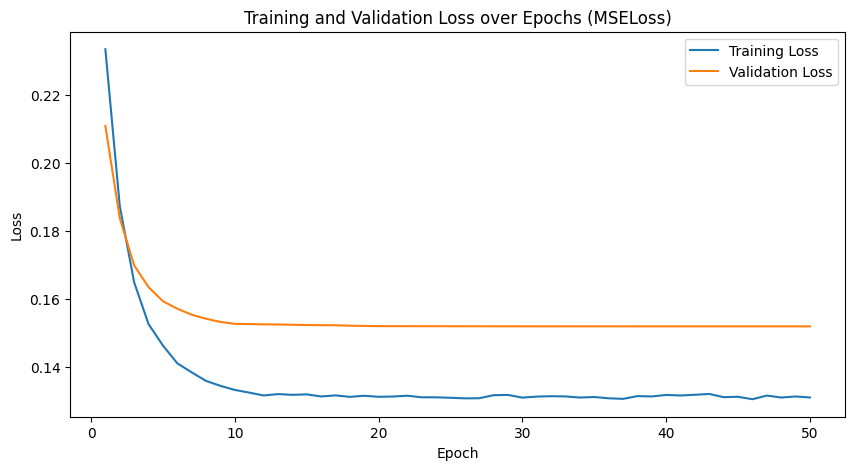

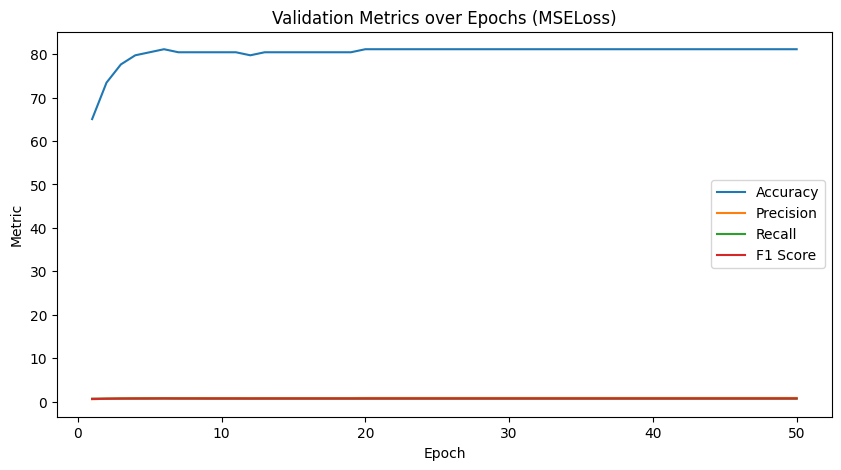

In [ ]:
# Using MSELoss for training the model on the Titanic dataset with improvements


mse_model = SimpleMLP(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_hidden_layers=num_hidden_layers,
    last_layer_activation_fn=nn.Sigmoid  # Added Sigmoid activation function
)

# Define the loss function using Mean Squared Error (MSELoss)
mse_loss_function = nn.MSELoss()

# Define the optimizer (Adam optimizer with a learning rate of 0.001)
mse_optimizer = torch.optim.Adam(mse_model.parameters(), lr=0.001)

# Define a learning rate scheduler to adjust the learning rate during training
mse_scheduler = StepLR(mse_optimizer, step_size=10, gamma=0.1)

# Instantiate the SimpleMLPTrainer with the model, loss function, optimizer, and scheduler
mse_trainer = SimpleMLPTrainer(
    model=mse_model,
    criterion=mse_loss_function,
    optimizer=mse_optimizer,
    scheduler=mse_scheduler,
    save_model=True,                    # Save the model when validation loss improves
    checkpoint_path='best_mse_model.pth'  # Path to save the best model
)

# Set the number of epochs for training
num_epochs = 50

# Implement early stopping parameters
early_stopping_patience = 5  # Stop training if validation loss doesn't improve for 5 consecutive epochs
best_val_loss = float('inf')
epochs_without_improvement = 0

# Lists to store training and validation metrics
mse_training_losses = []
mse_validation_losses = []
mse_validation_accuracies = []
mse_validation_precisions = []
mse_validation_recalls = []
mse_validation_f1s = []

# Training loop with early stopping and metric tracking
for epoch in range(num_epochs):
    # Training phase
    mse_model.train()
    running_loss = 0.0
    for batch_inputs, batch_targets in train_loader:
        mse_optimizer.zero_grad()
        predictions = mse_model(batch_inputs)
        loss = mse_loss_function(predictions, batch_targets)
        loss.backward()
        mse_optimizer.step()
        running_loss += loss.item()
    avg_training_loss = running_loss / len(train_loader)
    mse_training_losses.append(avg_training_loss)

    # Validation phase
    mse_model.eval()
    val_loss = 0.0
    all_targets = []
    all_predictions = []
    with torch.no_grad():
        for batch_inputs, batch_targets in val_loader:
            predictions = mse_model(batch_inputs)
            loss = mse_loss_function(predictions, batch_targets)
            val_loss += loss.item()

            # Since outputs are already probabilities, use them directly
            predicted_labels = (predictions >= 0.5).float().squeeze()
            all_predictions.extend(predicted_labels.cpu().numpy())
            all_targets.extend(batch_targets.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    mse_validation_losses.append(avg_val_loss)

    # Calculate additional metrics
    accuracy = (np.array(all_predictions) == np.array(all_targets).flatten()).mean() * 100
    precision = precision_score(all_targets, all_predictions, zero_division=0)
    recall = recall_score(all_targets, all_predictions, zero_division=0)
    f1 = f1_score(all_targets, all_predictions, zero_division=0)
    mse_validation_accuracies.append(accuracy)
    mse_validation_precisions.append(precision)
    mse_validation_recalls.append(recall)
    mse_validation_f1s.append(f1)

    # Print metrics
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Training Loss: {avg_training_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Check for improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        # Save the best model
        torch.save(mse_model.state_dict(), 'best_mse_model.pth')
        print("Validation loss improved, model saved.")
    else:
        epochs_without_improvement += 1
        print(f"No improvement in validation loss for {epochs_without_improvement} epochs.")

    # Early stopping
    if epochs_without_improvement >= early_stopping_patience:
        print("Early stopping triggered.")
        break

    # Step the scheduler
    mse_scheduler.step()

# Load the best model before evaluation
mse_model.load_state_dict(torch.load('best_mse_model.pth'))

# Evaluate the model on the validation set
final_val_loss, final_val_accuracy = mse_trainer.evaluate(val_loader)

# # Plot training and validation losses
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, len(mse_training_losses)+1), mse_training_losses, label='Training Loss')
# plt.plot(range(1, len(mse_validation_losses)+1), mse_validation_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss over Epochs (MSELoss)')
# plt.legend()
# plt.show()

# # Plot validation accuracy, precision, recall, and F1 score
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, len(mse_validation_accuracies)+1), mse_validation_accuracies, label='Accuracy')
# plt.plot(range(1, len(mse_validation_precisions)+1), mse_validation_precisions, label='Precision')
# plt.plot(range(1, len(mse_validation_recalls)+1), mse_validation_recalls, label='Recall')
# plt.plot(range(1, len(mse_validation_f1s)+1), mse_validation_f1s, label='F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('Metric')
# plt.title('Validation Metrics over Epochs (MSELoss)')
# plt.legend()
# plt.show()


### 3. NLLLoss (`torch.nn.NLLLoss`)
- **Description:** Negative Log-Likelihood Loss measures the likelihood of the target class under the predicted probability distribution.
- **Use Case:** Typically used in multi-class classification tasks, especially when combined with `log_softmax` activation.

Here is the mathematical formulation of NLLLoss:
\begin{equation}
\text{NLLLoss} = -\frac{1}{n} \sum_{i=1}^{n} \log(y_{i})
\end{equation}

I hope you note the logarithm in the formula. It's important! 

Why?


In this part, run your training with Relu at last layer. <span style="color:red; font-weight: bold;">Discuss </span> and explain the difference between the results of the two models. Find a proper solution to the problem.


In [ ]:


# Data loading and preprocessing
train_url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
response = requests.get(train_url, verify=False)
titanic_data = pd.read_csv(StringIO(response.text))

# Select relevant features and drop missing values
titanic_data = titanic_data[['Pclass', 'Sex', 'Age', 'Fare', 'Survived']].dropna()
titanic_data['Sex'] = titanic_data['Sex'].map({'male': 0, 'female': 1})

# Extract features and labels
feature_array = titanic_data[['Pclass', 'Sex', 'Age', 'Fare']].values
label_array = titanic_data['Survived'].values

# Scale features using StandardScaler
scaler = StandardScaler()
scaled_feature_array = scaler.fit_transform(feature_array)

# Convert numpy arrays to PyTorch tensors
feature_tensor = torch.tensor(scaled_feature_array, dtype=torch.float32)
# For NLLLoss, labels should be LongTensors with class indices
label_tensor = torch.tensor(label_array, dtype=torch.long)

# Create a TensorDataset from tensors
titanic_dataset = TensorDataset(feature_tensor, label_tensor)

# Split the dataset into training and validation sets
train_dataset_size = int(0.8 * len(titanic_dataset))
validation_dataset_size = len(titanic_dataset) - train_dataset_size
training_dataset, validation_dataset = random_split(
    titanic_dataset, [train_dataset_size, validation_dataset_size]
)

# Create DataLoaders for training and validation
training_loader = DataLoader(
    training_dataset, batch_size=32, shuffle=True
)
validation_loader = DataLoader(
    validation_dataset, batch_size=32, shuffle=False
)

# Define model parameters
input_dimension = feature_array.shape[1]  # Number of input features from the dataset
hidden_dimension = 16                     # Number of neurons in each hidden layer
output_dimension = 2                      # Output dimension for multi-class classification (number of classes)
number_of_hidden_layers = 2               # Total number of hidden layers in the model
num_epochs = 20                           # Number of epochs for training

# Model with ReLU as the last layer activation function
nll_relu_model = SimpleMLP(
    input_dim=input_dimension,
    hidden_dim=hidden_dimension,
    output_dim=output_dimension,
    num_hidden_layers=number_of_hidden_layers,
    last_layer_activation_fn=nn.ReLU  # Using ReLU as the last activation function
)

# Define the loss function and optimizer
nll_loss_function = nn.NLLLoss()
nll_optimizer = torch.optim.Adam(nll_relu_model.parameters(), lr=0.001)

# Instantiate the SimpleMLPTrainer with the model, loss function, and optimizer
nll_trainer = SimpleMLPTrainer(
    model=nll_relu_model,
    criterion=nll_loss_function,
    optimizer=nll_optimizer
)

# Train the model
try:
    nll_training_losses = nll_trainer.train(
        train_loader=training_loader,
        num_epochs=num_epochs,
        val_loader=validation_loader
    )
except Exception as e:
    print(f"An error occurred during training: {e}")

# Proper solution: Adjust the last activation function to LogSoftmax
# This ensures that the outputs are log-probabilities as required by NLLLoss
nll_logsoftmax_model = SimpleMLP(
    input_dim=input_dimension,
    hidden_dim=hidden_dimension,
    output_dim=output_dimension,
    num_hidden_layers=number_of_hidden_layers,
    last_layer_activation_fn=lambda: nn.LogSoftmax(dim=1)  # Using LogSoftmax as the last activation function
)

# Redefine the loss function and optimizer
nll_logsoftmax_optimizer = torch.optim.Adam(nll_logsoftmax_model.parameters(), lr=0.001)

# Instantiate the trainer with the corrected model
nll_logsoftmax_trainer = SimpleMLPTrainer(
    model=nll_logsoftmax_model,
    criterion=nll_loss_function,
    optimizer=nll_logsoftmax_optimizer
)

# Train the corrected model
nll_logsoftmax_training_losses = nll_logsoftmax_trainer.train(
    train_loader=training_loader,
    num_epochs=num_epochs,
    val_loader=validation_loader
)


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Epoch 1/20: 100%|██████████| 18/18 [00:00<00:00, 340.25it/s]


Epoch [1/20], Loss: -0.8111
Validation Loss: -1.1250, Accuracy: 47.55%


Epoch 2/20: 100%|██████████| 18/18 [00:00<00:00, 425.94it/s]


Epoch [2/20], Loss: -1.2510
Validation Loss: -1.6599, Accuracy: 48.25%


Epoch 3/20: 100%|██████████| 18/18 [00:00<00:00, 644.07it/s]


Epoch [3/20], Loss: -1.8502
Validation Loss: -2.3210, Accuracy: 47.55%


Epoch 4/20: 100%|██████████| 18/18 [00:00<00:00, 608.19it/s]


Epoch [4/20], Loss: -2.5660
Validation Loss: -3.0528, Accuracy: 53.85%


Epoch 5/20: 100%|██████████| 18/18 [00:00<00:00, 874.03it/s]


Epoch [5/20], Loss: -3.3508
Validation Loss: -3.9134, Accuracy: 55.94%


Epoch 6/20: 100%|██████████| 18/18 [00:00<00:00, 449.60it/s]


Epoch [6/20], Loss: -4.3061
Validation Loss: -4.9263, Accuracy: 56.64%


Epoch 7/20: 100%|██████████| 18/18 [00:00<00:00, 345.47it/s]


Epoch [7/20], Loss: -5.4499
Validation Loss: -6.1513, Accuracy: 59.44%


Epoch 8/20: 100%|██████████| 18/18 [00:00<00:00, 355.81it/s]


Epoch [8/20], Loss: -6.7668
Validation Loss: -7.6254, Accuracy: 65.03%


Epoch 9/20: 100%|██████████| 18/18 [00:00<00:00, 157.47it/s]


Epoch [9/20], Loss: -8.4183
Validation Loss: -9.3493, Accuracy: 65.73%


Epoch 10/20: 100%|██████████| 18/18 [00:00<00:00, 374.50it/s]


Epoch [10/20], Loss: -10.3022
Validation Loss: -11.4378, Accuracy: 67.13%


Epoch 11/20: 100%|██████████| 18/18 [00:00<00:00, 432.62it/s]


Epoch [11/20], Loss: -12.5406
Validation Loss: -13.8604, Accuracy: 69.93%


Epoch 12/20: 100%|██████████| 18/18 [00:00<00:00, 428.04it/s]


Epoch [12/20], Loss: -15.1631
Validation Loss: -16.6393, Accuracy: 70.63%


Epoch 13/20: 100%|██████████| 18/18 [00:00<00:00, 322.61it/s]


Epoch [13/20], Loss: -18.2372
Validation Loss: -19.9133, Accuracy: 72.73%


Epoch 14/20: 100%|██████████| 18/18 [00:00<00:00, 374.63it/s]


Epoch [14/20], Loss: -21.8062
Validation Loss: -23.7011, Accuracy: 72.73%


Epoch 15/20: 100%|██████████| 18/18 [00:00<00:00, 406.72it/s]


Epoch [15/20], Loss: -25.9689
Validation Loss: -28.0982, Accuracy: 72.03%


Epoch 16/20: 100%|██████████| 18/18 [00:00<00:00, 475.46it/s]


Epoch [16/20], Loss: -30.7140
Validation Loss: -33.2038, Accuracy: 72.03%


Epoch 17/20: 100%|██████████| 18/18 [00:00<00:00, 443.39it/s]


Epoch [17/20], Loss: -36.2996
Validation Loss: -38.9901, Accuracy: 71.33%


Epoch 18/20: 100%|██████████| 18/18 [00:00<00:00, 432.58it/s]


Epoch [18/20], Loss: -42.6624
Validation Loss: -45.5577, Accuracy: 67.13%


Epoch 19/20: 100%|██████████| 18/18 [00:00<00:00, 589.49it/s]


Epoch [19/20], Loss: -49.8115
Validation Loss: -53.0735, Accuracy: 49.65%


Epoch 20/20: 100%|██████████| 18/18 [00:00<00:00, 479.80it/s]


Epoch [20/20], Loss: -58.0678
Validation Loss: -61.4787, Accuracy: 48.95%


Epoch 1/20: 100%|██████████| 18/18 [00:00<00:00, 120.47it/s]


Epoch [1/20], Loss: 0.6199
Validation Loss: 0.6391, Accuracy: 69.23%


Epoch 2/20: 100%|██████████| 18/18 [00:00<00:00, 361.31it/s]


Epoch [2/20], Loss: 0.5367
Validation Loss: 0.5776, Accuracy: 75.52%


Epoch 3/20: 100%|██████████| 18/18 [00:00<00:00, 415.99it/s]


Epoch [3/20], Loss: 0.4946
Validation Loss: 0.5509, Accuracy: 76.92%


Epoch 4/20: 100%|██████████| 18/18 [00:00<00:00, 330.47it/s]


Epoch [4/20], Loss: 0.4745
Validation Loss: 0.5440, Accuracy: 76.92%


Epoch 5/20: 100%|██████████| 18/18 [00:00<00:00, 403.97it/s]


Epoch [5/20], Loss: 0.4644
Validation Loss: 0.5332, Accuracy: 75.52%


Epoch 6/20: 100%|██████████| 18/18 [00:00<00:00, 381.67it/s]


Epoch [6/20], Loss: 0.4540
Validation Loss: 0.5257, Accuracy: 76.22%


Epoch 7/20: 100%|██████████| 18/18 [00:00<00:00, 385.08it/s]


Epoch [7/20], Loss: 0.4512
Validation Loss: 0.5224, Accuracy: 76.22%


Epoch 8/20: 100%|██████████| 18/18 [00:00<00:00, 389.68it/s]


Epoch [8/20], Loss: 0.4446
Validation Loss: 0.5152, Accuracy: 76.22%


Epoch 9/20: 100%|██████████| 18/18 [00:00<00:00, 620.54it/s]


Epoch [9/20], Loss: 0.4397
Validation Loss: 0.5107, Accuracy: 76.22%


Epoch 10/20: 100%|██████████| 18/18 [00:00<00:00, 482.09it/s]


Epoch [10/20], Loss: 0.4372
Validation Loss: 0.5094, Accuracy: 76.92%


Epoch 11/20: 100%|██████████| 18/18 [00:00<00:00, 693.48it/s]


Epoch [11/20], Loss: 0.4341
Validation Loss: 0.5031, Accuracy: 76.22%


Epoch 12/20: 100%|██████████| 18/18 [00:00<00:00, 361.23it/s]


Epoch [12/20], Loss: 0.4309
Validation Loss: 0.5000, Accuracy: 76.22%


Epoch 13/20: 100%|██████████| 18/18 [00:00<00:00, 199.73it/s]


Epoch [13/20], Loss: 0.4267
Validation Loss: 0.5036, Accuracy: 75.52%


Epoch 14/20: 100%|██████████| 18/18 [00:00<00:00, 368.38it/s]


Epoch [14/20], Loss: 0.4258
Validation Loss: 0.4973, Accuracy: 76.22%


Epoch 15/20: 100%|██████████| 18/18 [00:00<00:00, 422.99it/s]


Epoch [15/20], Loss: 0.4230
Validation Loss: 0.4941, Accuracy: 75.52%


Epoch 16/20: 100%|██████████| 18/18 [00:00<00:00, 505.92it/s]


Epoch [16/20], Loss: 0.4209
Validation Loss: 0.4934, Accuracy: 75.52%


Epoch 17/20: 100%|██████████| 18/18 [00:00<00:00, 288.60it/s]


Epoch [17/20], Loss: 0.4195
Validation Loss: 0.4944, Accuracy: 75.52%


Epoch 18/20: 100%|██████████| 18/18 [00:00<00:00, 403.32it/s]


Epoch [18/20], Loss: 0.4171
Validation Loss: 0.4955, Accuracy: 75.52%


Epoch 19/20: 100%|██████████| 18/18 [00:00<00:00, 352.79it/s]


Epoch [19/20], Loss: 0.4147
Validation Loss: 0.4974, Accuracy: 75.52%


Epoch 20/20: 100%|██████████| 18/18 [00:00<00:00, 366.30it/s]

Epoch [20/20], Loss: 0.4161
Validation Loss: 0.4982, Accuracy: 76.22%


**Your reason for your choice:**

**Difference between the two models:**

- **Model with ReLU Activation in the Last Layer:**

  - **Outputs:** Using `nn.ReLU` as the last activation function produces non-negative outputs that are not normalized and do not represent log-probabilities.
  - **Loss Behavior:** The training loss becomes increasingly negative over epochs (as seen in the results), which is not typical or meaningful for a loss function. Negative loss values indicate that the loss computation is not functioning as intended.
  - **Model Performance:** The accuracy fluctuates and eventually decreases, suggesting that the model is not learning effectively.

- **Model with LogSoftmax Activation in the Last Layer:**

  - **Outputs:** Using `nn.LogSoftmax(dim=1)` ensures that the model outputs are log-probabilities. This activation function applies softmax to produce probabilities that sum to one and then takes the logarithm.
  - **Loss Behavior:** The training loss decreases over epochs, converging towards a minimum value. This is expected behavior for a properly functioning loss function.
  - **Model Performance:** The validation accuracy improves and stabilizes at a higher percentage compared to the model with ReLU, indicating effective learning.

**Explanation:**

- **Importance of the Logarithm in NLLLoss:**

  - The `nn.NLLLoss` function computes the negative log-likelihood loss, which requires the input to be log-probabilities of the classes.
  - The mathematical formulation is:

    \[
    \text{NLLLoss} = -\frac{1}{n} \sum_{i=1}^{n} \log(p_i)
    \]

    where \( p_i \) is the predicted probability of the correct class for sample \( i \).

- **Why ReLU is Inappropriate:**

  - **ReLU Outputs:** The ReLU activation function outputs values in the range \([0, \infty)\), which are not log-probabilities.
  - **Mismatch with NLLLoss:** Feeding these non-logarithmic, non-normalized outputs into `nn.NLLLoss` leads to incorrect loss calculations and ineffective training.
  - **Resulting Issues:** The loss becomes negative and decreases indefinitely, and the model fails to learn meaningful patterns from the data.

- **Why LogSoftmax is Appropriate:**

  - **LogSoftmax Outputs:** The `nn.LogSoftmax(dim=1)` activation function produces outputs that are log-probabilities, ensuring that after exponentiation, the probabilities sum to one.
  - **Compatibility with NLLLoss:** Since `nn.NLLLoss` expects log-probabilities, using `nn.LogSoftmax` aligns the model's outputs with the loss function's requirements.
  - **Effective Training:** This leads to meaningful loss values that decrease over time, allowing the model to learn effectively and improve accuracy.

**Proper Solution:**

- **Adjust the Last Activation Function:**

  - Replace `nn.ReLU` with `nn.LogSoftmax(dim=1)` in the last layer of the model.
  - This ensures that the outputs are suitable for `nn.NLLLoss`.

- **Alternative Approach:**

  - Use `nn.CrossEntropyLoss` instead of `nn.NLLLoss` and remove the last activation function.
  - `nn.CrossEntropyLoss` combines `nn.LogSoftmax` and `nn.NLLLoss` internally and works directly with raw logits.



I chose to adjust the last activation function to `nn.LogSoftmax(dim=1)` because it produces log-probabilities required by `nn.NLLLoss`. Using `nn.ReLU` was inappropriate since it does not output log-probabilities, leading to incorrect loss calculations and ineffective training.

By ensuring that the model's outputs align with the loss function's expectations, the training process becomes effective, as evidenced by the decreasing loss and increasing accuracy in the results. This adjustment is crucial for the model to learn meaningful patterns and make accurate predictions.

**Conclusion:**

- The mismatch between the activation function and the loss function can severely impact model training.
- Using `nn.LogSoftmax` with `nn.NLLLoss` ensures compatibility and effective learning.
- Always ensure that the outputs of your model are appropriate for the loss function being used.


### 4. CrossEntropyLoss (`torch.nn.CrossEntropyLoss`)
- **Description:** Combines `LogSoftmax` and `NLLLoss` in one single class. It computes the cross-entropy loss between the target and the output logits.
- **Use Case:** Widely used for multi-class classification problems.

The mathematical formulation of CrossEntropyLoss is as follows:
\begin{equation}
  \text{CrossEntropy}(y, \hat{y}) = - \sum_{i=1}^{C} y_i \log\left(\frac{e^{\hat{y}_i}}{\sum_{j=1}^{C} e^{\hat{y}_j}}\right)
\end{equation}
  where:
  - \( C \) is the number of classes,
  - \( y_i \) is a one-hot encoded target vector (or a scalar class label),
  - \( \hat{y}_i \) represents the logits (unnormalized model outputs) for each class.
  
  In practice, `torch.nn.CrossEntropyLoss` expects raw logits as input and internally applies the softmax function to convert the logits into probabilities, followed by the negative log-likelihood computation.

- **Background:** Cross-entropy measures the difference between the true distribution \( y \) and the predicted distribution \( \hat{y} \). The function minimizes the negative log-probability assigned to the correct class, effectively penalizing predictions that deviate from the true class, making it a standard choice for classification tasks in deep learning.

Now, let's implement a class called `SimpleMLP_Loss` that has the following architecture:


In [ ]:

# Instantiate the SimpleMLP model without an activation function in the last layer
cross_entropy_model = SimpleMLP(
    input_dim=input_size,
    hidden_dim=hidden_size,
    output_dim=output_size,
    num_hidden_layers=num_hidden_layers,
    last_layer_activation_fn=None  # No activation function in the last layer for CrossEntropyLoss
)

# Define the loss function using CrossEntropyLoss
cross_entropy_loss_fn = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer with a learning rate of 0.001)
cross_entropy_optimizer = torch.optim.Adam(cross_entropy_model.parameters(), lr=0.001)

# Instantiate the SimpleMLPTrainer with the model, loss function, and optimizer
cross_entropy_trainer = SimpleMLPTrainer(
    model=cross_entropy_model,
    criterion=cross_entropy_loss_fn,
    optimizer=cross_entropy_optimizer
)

# Implement early stopping parameters
best_val_loss = float('inf')
early_stopping_patience = 5
epochs_without_improvement = 0

# Lists to store training and validation metrics
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1_scores = []

# Training loop with early stopping and metric tracking
for epoch in range(num_epochs):
    # Training phase
    cross_entropy_model.train()
    running_loss = 0.0
    for batch_inputs, batch_labels in tqdm(
        train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"
    ):
        cross_entropy_optimizer.zero_grad()
        outputs = cross_entropy_model(batch_inputs)
        loss = cross_entropy_loss_fn(outputs, batch_labels)
        loss.backward()
        cross_entropy_optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    cross_entropy_model.eval()
    val_loss = 0.0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for batch_inputs, batch_labels in val_dataloader:
            outputs = cross_entropy_model(batch_inputs)
            loss = cross_entropy_loss_fn(outputs, batch_labels)
            val_loss += loss.item()
            
            # Get predicted class labels
            _, predicted_classes = torch.max(outputs, 1)
            all_predictions.extend(predicted_classes.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)
    
    # Calculate validation metrics
    accuracy = (np.array(all_predictions) == np.array(all_labels)).mean() * 100
    precision = precision_score(all_labels, all_predictions, zero_division=0)
    recall = recall_score(all_labels, all_predictions, zero_division=0)
    f1 = f1_score(all_labels, all_predictions, zero_division=0)
    val_accuracies.append(accuracy)
    val_precisions.append(precision)
    val_recalls.append(recall)
    val_f1_scores.append(f1)
    
    # Print epoch metrics
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Check for improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        # Save the best model
        torch.save(cross_entropy_model.state_dict(), 'best_cross_entropy_model.pth')
        print("Validation loss improved, model saved.")
    else:
        epochs_without_improvement += 1
        print(f"No improvement in validation loss for {epochs_without_improvement} epochs.")
    
    # Early stopping
    if epochs_without_improvement >= early_stopping_patience:
        print("Early stopping triggered.")
        break

# Load the best model before evaluation
cross_entropy_model.load_state_dict(torch.load('best_cross_entropy_model.pth'))

# Evaluate the model on the validation set
final_val_loss, final_val_accuracy = cross_entropy_trainer.evaluate(val_dataloader)
print(f"Final Validation Loss: {final_val_loss:.4f}, Accuracy: {final_val_accuracy:.2f}%")

# # Plot training and validation losses
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
# plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss over Epochs (CrossEntropyLoss)')
# plt.legend()
# plt.show()

# # Plot validation accuracy, precision, recall, and F1 score
# plt.figure(figsize=(10, 5))
# plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Accuracy')
# plt.plot(range(1, len(val_precisions)+1), val_precisions, label='Precision')
# plt.plot(range(1, len(val_recalls)+1), val_recalls, label='Recall')
# plt.plot(range(1, len(val_f1_scores)+1), val_f1_scores, label='F1 Score')
# plt.xlabel('Epoch')
# plt.ylabel('Metric')
# plt.title('Validation Metrics over Epochs (CrossEntropyLoss)')
# plt.legend()
# plt.show()


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Epoch 1/50: 100%|██████████| 18/18 [00:00<00:00, 381.91it/s]


Epoch [1/50]
Training Loss: 0.9784
Validation Loss: 0.7404
Validation Accuracy: 46.85%
Precision: 0.3594
Recall: 0.3966
F1 Score: 0.3770
Validation loss improved, model saved.


Epoch 2/50: 100%|██████████| 18/18 [00:00<00:00, 690.51it/s]


Epoch [2/50]
Training Loss: 0.7031
Validation Loss: 0.5735
Validation Accuracy: 79.02%
Precision: 0.7121
Recall: 0.8103
F1 Score: 0.7581
Validation loss improved, model saved.


Epoch 3/50: 100%|██████████| 18/18 [00:00<00:00, 418.18it/s]


Epoch [3/50]
Training Loss: 0.5665
Validation Loss: 0.5104
Validation Accuracy: 79.02%
Precision: 0.7500
Recall: 0.7241
F1 Score: 0.7368
Validation loss improved, model saved.


Epoch 4/50: 100%|██████████| 18/18 [00:00<00:00, 449.35it/s]


Epoch [4/50]
Training Loss: 0.5068
Validation Loss: 0.4776
Validation Accuracy: 79.02%
Precision: 0.8043
Recall: 0.6379
F1 Score: 0.7115
Validation loss improved, model saved.


Epoch 5/50: 100%|██████████| 18/18 [00:00<00:00, 443.89it/s]


Epoch [5/50]
Training Loss: 0.4812
Validation Loss: 0.4678
Validation Accuracy: 79.02%
Precision: 0.8182
Recall: 0.6207
F1 Score: 0.7059
Validation loss improved, model saved.


Epoch 6/50: 100%|██████████| 18/18 [00:00<00:00, 167.98it/s]


Epoch [6/50]
Training Loss: 0.4708
Validation Loss: 0.4655
Validation Accuracy: 76.92%
Precision: 0.7660
Recall: 0.6207
F1 Score: 0.6857
Validation loss improved, model saved.


Epoch 7/50: 100%|██████████| 18/18 [00:00<00:00, 589.62it/s]


Epoch [7/50]
Training Loss: 0.4649
Validation Loss: 0.4634
Validation Accuracy: 76.92%
Precision: 0.7273
Recall: 0.6897
F1 Score: 0.7080
Validation loss improved, model saved.


Epoch 8/50: 100%|██████████| 18/18 [00:00<00:00, 749.36it/s]


Epoch [8/50]
Training Loss: 0.4592
Validation Loss: 0.4616
Validation Accuracy: 76.92%
Precision: 0.7273
Recall: 0.6897
F1 Score: 0.7080
Validation loss improved, model saved.


Epoch 9/50: 100%|██████████| 18/18 [00:00<00:00, 443.17it/s]


Epoch [9/50]
Training Loss: 0.4562
Validation Loss: 0.4611
Validation Accuracy: 76.22%
Precision: 0.7143
Recall: 0.6897
F1 Score: 0.7018
Validation loss improved, model saved.


Epoch 10/50: 100%|██████████| 18/18 [00:00<00:00, 781.35it/s]


Epoch [10/50]
Training Loss: 0.4517
Validation Loss: 0.4603
Validation Accuracy: 76.22%
Precision: 0.7143
Recall: 0.6897
F1 Score: 0.7018
Validation loss improved, model saved.


Epoch 11/50: 100%|██████████| 18/18 [00:00<00:00, 477.90it/s]


Epoch [11/50]
Training Loss: 0.4505
Validation Loss: 0.4602
Validation Accuracy: 76.22%
Precision: 0.7143
Recall: 0.6897
F1 Score: 0.7018
Validation loss improved, model saved.


Epoch 12/50: 100%|██████████| 18/18 [00:00<00:00, 460.92it/s]

Epoch [12/50]
Training Loss: 0.4497
Validation Loss: 0.4596
Validation Accuracy: 76.22%
Precision: 0.7143
Recall: 0.6897
F1 Score: 0.7018


Validation loss improved, model saved.


Epoch 13/50: 100%|██████████| 18/18 [00:00<00:00, 428.16it/s]


Epoch [13/50]
Training Loss: 0.4465
Validation Loss: 0.4557
Validation Accuracy: 74.83%
Precision: 0.7200
Recall: 0.6207
F1 Score: 0.6667
Validation loss improved, model saved.


Epoch 14/50: 100%|██████████| 18/18 [00:00<00:00, 403.59it/s]


Epoch [14/50]
Training Loss: 0.4431
Validation Loss: 0.4548
Validation Accuracy: 76.92%
Precision: 0.7273
Recall: 0.6897
F1 Score: 0.7080
Validation loss improved, model saved.


Epoch 15/50: 100%|██████████| 18/18 [00:00<00:00, 473.79it/s]


Epoch [15/50]
Training Loss: 0.4433
Validation Loss: 0.4537
Validation Accuracy: 76.92%
Precision: 0.7358
Recall: 0.6724
F1 Score: 0.7027
Validation loss improved, model saved.


Epoch 16/50: 100%|██████████| 18/18 [00:00<00:00, 409.03it/s]


Epoch [16/50]
Training Loss: 0.4395
Validation Loss: 0.4548
Validation Accuracy: 77.62%
Precision: 0.7321
Recall: 0.7069
F1 Score: 0.7193
No improvement in validation loss for 1 epochs.


Epoch 17/50: 100%|██████████| 18/18 [00:00<00:00, 155.00it/s]


Epoch [17/50]
Training Loss: 0.4385
Validation Loss: 0.4534
Validation Accuracy: 76.22%
Precision: 0.7400
Recall: 0.6379
F1 Score: 0.6852
Validation loss improved, model saved.


Epoch 18/50: 100%|██████████| 18/18 [00:00<00:00, 434.15it/s]


Epoch [18/50]
Training Loss: 0.4348
Validation Loss: 0.4538
Validation Accuracy: 77.62%
Precision: 0.7321
Recall: 0.7069
F1 Score: 0.7193
No improvement in validation loss for 1 epochs.


Epoch 19/50: 100%|██████████| 18/18 [00:00<00:00, 499.38it/s]


Epoch [19/50]
Training Loss: 0.4364
Validation Loss: 0.4531
Validation Accuracy: 77.62%
Precision: 0.7321
Recall: 0.7069
F1 Score: 0.7193
Validation loss improved, model saved.


Epoch 20/50: 100%|██████████| 18/18 [00:00<00:00, 378.42it/s]


Epoch [20/50]
Training Loss: 0.4318
Validation Loss: 0.4498
Validation Accuracy: 76.92%
Precision: 0.7358
Recall: 0.6724
F1 Score: 0.7027
Validation loss improved, model saved.


Epoch 21/50: 100%|██████████| 18/18 [00:00<00:00, 609.83it/s]


Epoch [21/50]
Training Loss: 0.4296
Validation Loss: 0.4508
Validation Accuracy: 77.62%
Precision: 0.7321
Recall: 0.7069
F1 Score: 0.7193
No improvement in validation loss for 1 epochs.


Epoch 22/50: 100%|██████████| 18/18 [00:00<00:00, 734.26it/s]


Epoch [22/50]
Training Loss: 0.4288
Validation Loss: 0.4515
Validation Accuracy: 78.32%
Precision: 0.7455
Recall: 0.7069
F1 Score: 0.7257
No improvement in validation loss for 2 epochs.


Epoch 23/50: 100%|██████████| 18/18 [00:00<00:00, 521.19it/s]


Epoch [23/50]
Training Loss: 0.4269
Validation Loss: 0.4485
Validation Accuracy: 78.32%
Precision: 0.7547
Recall: 0.6897
F1 Score: 0.7207
Validation loss improved, model saved.


Epoch 24/50: 100%|██████████| 18/18 [00:00<00:00, 422.68it/s]


Epoch [24/50]
Training Loss: 0.4251
Validation Loss: 0.4477
Validation Accuracy: 76.22%
Precision: 0.7609
Recall: 0.6034
F1 Score: 0.6731
Validation loss improved, model saved.


Epoch 25/50: 100%|██████████| 18/18 [00:00<00:00, 473.17it/s]


Epoch [25/50]
Training Loss: 0.4252
Validation Loss: 0.4472
Validation Accuracy: 77.62%
Precision: 0.7500
Recall: 0.6724
F1 Score: 0.7091
Validation loss improved, model saved.


Epoch 26/50: 100%|██████████| 18/18 [00:00<00:00, 491.78it/s]


Epoch [26/50]
Training Loss: 0.4219
Validation Loss: 0.4458
Validation Accuracy: 77.62%
Precision: 0.7708
Recall: 0.6379
F1 Score: 0.6981
Validation loss improved, model saved.


Epoch 27/50: 100%|██████████| 18/18 [00:00<00:00, 486.26it/s]


Epoch [27/50]
Training Loss: 0.4234
Validation Loss: 0.4478
Validation Accuracy: 77.62%
Precision: 0.7600
Recall: 0.6552
F1 Score: 0.7037
No improvement in validation loss for 1 epochs.


Epoch 28/50: 100%|██████████| 18/18 [00:00<00:00, 457.19it/s]


Epoch [28/50]
Training Loss: 0.4185
Validation Loss: 0.4473
Validation Accuracy: 77.62%
Precision: 0.7500
Recall: 0.6724
F1 Score: 0.7091
No improvement in validation loss for 2 epochs.


Epoch 29/50: 100%|██████████| 18/18 [00:00<00:00, 292.88it/s]


Epoch [29/50]
Training Loss: 0.4189
Validation Loss: 0.4446
Validation Accuracy: 76.92%
Precision: 0.7778
Recall: 0.6034
F1 Score: 0.6796
Validation loss improved, model saved.


Epoch 30/50: 100%|██████████| 18/18 [00:00<00:00, 350.37it/s]

Epoch [30/50]


Training Loss: 0.4171
Validation Loss: 0.4482
Validation Accuracy: 78.32%
Precision: 0.7455
Recall: 0.7069
F1 Score: 0.7257
No improvement in validation loss for 1 epochs.


Epoch 31/50: 100%|██████████| 18/18 [00:00<00:00, 438.49it/s]


Epoch [31/50]
Training Loss: 0.4149
Validation Loss: 0.4453
Validation Accuracy: 78.32%
Precision: 0.7755
Recall: 0.6552
F1 Score: 0.7103
No improvement in validation loss for 2 epochs.


Epoch 32/50: 100%|██████████| 18/18 [00:00<00:00, 466.16it/s]


Epoch [32/50]
Training Loss: 0.4160
Validation Loss: 0.4452
Validation Accuracy: 77.62%
Precision: 0.7826
Recall: 0.6207
F1 Score: 0.6923
No improvement in validation loss for 3 epochs.


Epoch 33/50: 100%|██████████| 18/18 [00:00<00:00, 368.59it/s]


Epoch [33/50]
Training Loss: 0.4126
Validation Loss: 0.4444
Validation Accuracy: 77.62%
Precision: 0.7600
Recall: 0.6552
F1 Score: 0.7037
Validation loss improved, model saved.


Epoch 34/50: 100%|██████████| 18/18 [00:00<00:00, 536.92it/s]


Epoch [34/50]
Training Loss: 0.4136
Validation Loss: 0.4426
Validation Accuracy: 77.62%
Precision: 0.7955
Recall: 0.6034
F1 Score: 0.6863
Validation loss improved, model saved.


Epoch 35/50: 100%|██████████| 18/18 [00:00<00:00, 398.97it/s]


Epoch [35/50]
Training Loss: 0.4139
Validation Loss: 0.4436
Validation Accuracy: 77.62%
Precision: 0.7708
Recall: 0.6379
F1 Score: 0.6981
No improvement in validation loss for 1 epochs.


Epoch 36/50: 100%|██████████| 18/18 [00:00<00:00, 516.54it/s]


Epoch [36/50]
Training Loss: 0.4120
Validation Loss: 0.4424
Validation Accuracy: 77.62%
Precision: 0.8095
Recall: 0.5862
F1 Score: 0.6800
Validation loss improved, model saved.


Epoch 37/50: 100%|██████████| 18/18 [00:00<00:00, 703.79it/s]


Epoch [37/50]
Training Loss: 0.4106
Validation Loss: 0.4426
Validation Accuracy: 77.62%
Precision: 0.7708
Recall: 0.6379
F1 Score: 0.6981
No improvement in validation loss for 1 epochs.


Epoch 38/50: 100%|██████████| 18/18 [00:00<00:00, 589.83it/s]


Epoch [38/50]
Training Loss: 0.4109
Validation Loss: 0.4425
Validation Accuracy: 78.32%
Precision: 0.8140
Recall: 0.6034
F1 Score: 0.6931
No improvement in validation loss for 2 epochs.


Epoch 39/50: 100%|██████████| 18/18 [00:00<00:00, 390.79it/s]


Epoch [39/50]
Training Loss: 0.4104
Validation Loss: 0.4406
Validation Accuracy: 78.32%
Precision: 0.8140
Recall: 0.6034
F1 Score: 0.6931
Validation loss improved, model saved.


Epoch 40/50: 100%|██████████| 18/18 [00:00<00:00, 449.49it/s]


Epoch [40/50]
Training Loss: 0.4090
Validation Loss: 0.4424
Validation Accuracy: 77.62%
Precision: 0.7826
Recall: 0.6207
F1 Score: 0.6923
No improvement in validation loss for 1 epochs.


Epoch 41/50: 100%|██████████| 18/18 [00:00<00:00, 408.66it/s]


Epoch [41/50]
Training Loss: 0.4117
Validation Loss: 0.4417
Validation Accuracy: 78.32%
Precision: 0.8140
Recall: 0.6034
F1 Score: 0.6931
No improvement in validation loss for 2 epochs.


Epoch 42/50: 100%|██████████| 18/18 [00:00<00:00, 342.43it/s]


Epoch [42/50]
Training Loss: 0.4077
Validation Loss: 0.4424
Validation Accuracy: 76.92%
Precision: 0.7551
Recall: 0.6379
F1 Score: 0.6916
No improvement in validation loss for 3 epochs.


Epoch 43/50: 100%|██████████| 18/18 [00:00<00:00, 422.78it/s]


Epoch [43/50]
Training Loss: 0.4081
Validation Loss: 0.4417
Validation Accuracy: 78.32%
Precision: 0.8140
Recall: 0.6034
F1 Score: 0.6931
No improvement in validation loss for 4 epochs.


Epoch 44/50: 100%|██████████| 18/18 [00:00<00:00, 618.15it/s]


Epoch [44/50]
Training Loss: 0.4067
Validation Loss: 0.4405
Validation Accuracy: 78.32%
Precision: 0.8140
Recall: 0.6034
F1 Score: 0.6931
Validation loss improved, model saved.


Epoch 45/50: 100%|██████████| 18/18 [00:00<00:00, 461.19it/s]


Epoch [45/50]
Training Loss: 0.4085
Validation Loss: 0.4385
Validation Accuracy: 78.32%
Precision: 0.8293
Recall: 0.5862
F1 Score: 0.6869
Validation loss improved, model saved.


Epoch 46/50: 100%|██████████| 18/18 [00:00<00:00, 418.19it/s]


Epoch [46/50]
Training Loss: 0.4069
Validation Loss: 0.4429
Validation Accuracy: 77.62%
Precision: 0.7826
Recall: 0.6207
F1 Score: 0.6923
No improvement in validation loss for 1 epochs.


Epoch 47/50: 100%|██████████| 18/18 [00:00<00:00, 448.42it/s]


Epoch [47/50]
Training Loss: 0.4072
Validation Loss: 0.4393
Validation Accuracy: 79.02%
Precision: 0.8333
Recall: 0.6034
F1 Score: 0.7000
No improvement in validation loss for 2 epochs.


Epoch 48/50: 100%|██████████| 18/18 [00:00<00:00, 449.55it/s]


Epoch [48/50]
Training Loss: 0.4040
Validation Loss: 0.4409
Validation Accuracy: 79.02%
Precision: 0.8182
Recall: 0.6207
F1 Score: 0.7059
No improvement in validation loss for 3 epochs.


Epoch 49/50: 100%|██████████| 18/18 [00:00<00:00, 570.59it/s]


Epoch [49/50]
Training Loss: 0.4062
Validation Loss: 0.4378
Validation Accuracy: 77.62%
Precision: 0.8095
Recall: 0.5862
F1 Score: 0.6800
Validation loss improved, model saved.


Epoch 50/50: 100%|██████████| 18/18 [00:00<00:00, 388.32it/s]

Epoch [50/50]
Training Loss: 0.4036
Validation Loss: 0.4390
Validation Accuracy: 79.02%
Precision: 0.8182
Recall: 0.6207
F1 Score: 0.7059
No improvement in validation loss for 1 epochs.


Validation Loss: 0.4378, Accuracy: 77.62%
Final Validation Loss: 0.4378, Accuracy: 77.62%



### 5. KLDivLoss (`torch.nn.KLDivLoss`)
- **Description:** Kullback-Leibler Divergence Loss measures how one probability distribution diverges from a second, reference distribution. Unlike other loss functions that focus on classification, KL divergence specifically compares the relative entropy between two distributions. It quantifies the information loss when using the predicted distribution to approximate the true distribution. 

- **Mathematical Function:**
\begin{equation}
  \text{KL}(P \parallel Q) = \sum_{i=1}^{C} P(i) \left( \log P(i) - \log Q(i) \right)
\end{equation}
  where:
  - \( P \) is the target (true) probability distribution,
  - \( Q \) is the predicted distribution (often the output of `log_softmax`),
  - \( C \) is the number of classes.

  KL divergence is always non-negative, and it equals zero if the two distributions are identical. The loss function expects the model's output to be in the form of log-probabilities (using `log_softmax`) and compares this against a target probability distribution, which is typically a normalized distribution (using softmax).

- **Use Case:** KLDivLoss is frequently used in:
  - **Variational Autoencoders (VAEs):** In VAEs, KL divergence is used to measure how much the learned latent space distribution deviates from a prior distribution (often Gaussian).
  - **Knowledge Distillation:** In teacher-student models, KL divergence is used to transfer the "soft" knowledge from a teacher model to a student model by comparing their output probability distributions.
  - **Reinforcement Learning:** It can be used to update policies while minimizing the divergence from a previous policy.

- **Background:** Kullback-Leibler divergence, a core concept in information theory, measures the inefficiency of assuming the predicted distribution \( Q \) when the true distribution is \( P \). It is asymmetric, meaning that \( KL(P \parallel Q) \neq KL(Q \parallel P) \), so the direction of the comparison matters.

Again, in this part, run your training with Relu at last layer. <span style="color:red; font-weight: bold;">Discuss </span> and explain the difference between the results of the two models. Find a proper solution to the problem.


In [ ]:

from torch.nn import KLDivLoss

# Run with ReLU activation function (Incorrect setup for KLDivLoss)
kl_relu_model = SimpleMLP(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_hidden_layers=num_hidden_layers,
    last_layer_activation_fn=nn.ReLU  # Using ReLU as the last activation function
)

# Define the loss function and optimizer
kl_loss_function = KLDivLoss(reduction="batchmean")
kl_relu_optimizer = torch.optim.Adam(kl_relu_model.parameters(), lr=0.001)

# Instantiate the trainer
kl_relu_trainer = SimpleMLPTrainer(
    model=kl_relu_model,
    criterion=kl_loss_function,
    optimizer=kl_relu_optimizer
)

# Train the model with ReLU activation
try:
    kl_relu_training_losses = kl_relu_trainer.train(
        train_loader=train_loader,
        num_epochs=num_epochs,
        val_loader=val_loader
    )
except Exception as e:
    print(f"An error occurred during training with ReLU activation: {e}")

# Evaluate the model
print('Evaluation with ReLU activation:')
kl_relu_val_loss, kl_relu_accuracy = kl_relu_trainer.evaluate(val_loader)

# Proper solution: Use LogSoftmax as the last activation function
# This ensures that the outputs are log-probabilities as required by KLDivLoss
kl_logsoftmax_model = SimpleMLP(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=output_dim,
    num_hidden_layers=num_hidden_layers,
    last_layer_activation_fn=lambda: nn.LogSoftmax(dim=1)  # Using LogSoftmax
)

# Define the optimizer
kl_logsoftmax_optimizer = torch.optim.Adam(kl_logsoftmax_model.parameters(), lr=0.001)

# Instantiate the trainer with the corrected model
kl_logsoftmax_trainer = SimpleMLPTrainer(
    model=kl_logsoftmax_model,
    criterion=kl_loss_function,
    optimizer=kl_logsoftmax_optimizer
)

# Train the corrected model
kl_logsoftmax_training_losses = kl_logsoftmax_trainer.train(
    train_loader=train_loader,
    num_epochs=num_epochs,
    val_loader=val_loader
)

# Evaluate the corrected model
print('Evaluation with LogSoftmax activation:')
kl_logsoftmax_val_loss, kl_logsoftmax_accuracy = kl_logsoftmax_trainer.evaluate(val_loader)


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\urllib3\connectionpool.py:1095: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raw.githubusercontent.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
Epoch 1/20: 100%|██████████| 18/18 [00:00<00:00, 521.11it/s]


Epoch [1/20], Loss: -0.4867
Validation Loss: -0.5903, Accuracy: 34.27%


Epoch 2/20: 100%|██████████| 18/18 [00:00<00:00, 551.73it/s]


Epoch [2/20], Loss: -0.9431
Validation Loss: -1.0901, Accuracy: 35.66%


Epoch 3/20: 100%|██████████| 18/18 [00:00<00:00, 392.79it/s]


Epoch [3/20], Loss: -1.5156
Validation Loss: -1.6582, Accuracy: 55.24%


Epoch 4/20: 100%|██████████| 18/18 [00:00<00:00, 328.76it/s]


Epoch [4/20], Loss: -2.1626
Validation Loss: -2.3034, Accuracy: 61.54%


Epoch 5/20: 100%|██████████| 18/18 [00:00<00:00, 613.24it/s]


Epoch [5/20], Loss: -2.9061
Validation Loss: -3.1104, Accuracy: 64.34%


Epoch 6/20: 100%|██████████| 18/18 [00:00<00:00, 491.50it/s]


Epoch [6/20], Loss: -3.8187
Validation Loss: -4.0886, Accuracy: 65.73%


Epoch 7/20: 100%|██████████| 18/18 [00:00<00:00, 464.76it/s]


Epoch [7/20], Loss: -4.9138
Validation Loss: -5.2877, Accuracy: 65.73%


Epoch 8/20: 100%|██████████| 18/18 [00:00<00:00, 548.68it/s]


Epoch [8/20], Loss: -6.2926
Validation Loss: -6.7117, Accuracy: 66.43%


Epoch 9/20: 100%|██████████| 18/18 [00:00<00:00, 502.96it/s]


Epoch [9/20], Loss: -7.8670
Validation Loss: -8.4641, Accuracy: 66.43%


Epoch 10/20: 100%|██████████| 18/18 [00:00<00:00, 813.20it/s]


Epoch [10/20], Loss: -9.7904
Validation Loss: -10.5272, Accuracy: 68.53%


Epoch 11/20: 100%|██████████| 18/18 [00:00<00:00, 467.77it/s]


Epoch [11/20], Loss: -12.0980
Validation Loss: -12.9853, Accuracy: 69.93%


Epoch 12/20: 100%|██████████| 18/18 [00:00<00:00, 449.57it/s]


Epoch [12/20], Loss: -14.8045
Validation Loss: -15.9412, Accuracy: 69.23%


Epoch 13/20: 100%|██████████| 18/18 [00:00<00:00, 443.20it/s]


Epoch [13/20], Loss: -18.1080
Validation Loss: -19.5862, Accuracy: 69.23%


Epoch 14/20: 100%|██████████| 18/18 [00:00<00:00, 678.29it/s]


Epoch [14/20], Loss: -22.1048
Validation Loss: -23.9907, Accuracy: 69.23%


Epoch 15/20: 100%|██████████| 18/18 [00:00<00:00, 484.29it/s]


Epoch [15/20], Loss: -26.9188
Validation Loss: -29.3007, Accuracy: 68.53%


Epoch 16/20: 100%|██████████| 18/18 [00:00<00:00, 477.61it/s]


Epoch [16/20], Loss: -32.6598
Validation Loss: -35.6355, Accuracy: 68.53%


Epoch 17/20: 100%|██████████| 18/18 [00:00<00:00, 517.53it/s]


Epoch [17/20], Loss: -39.4853
Validation Loss: -43.1792, Accuracy: 68.53%


Epoch 18/20: 100%|██████████| 18/18 [00:00<00:00, 756.48it/s]


Epoch [18/20], Loss: -47.4719
Validation Loss: -52.0624, Accuracy: 69.93%


Epoch 19/20: 100%|██████████| 18/18 [00:00<00:00, 545.62it/s]


Epoch [19/20], Loss: -56.8270
Validation Loss: -62.5149, Accuracy: 71.33%


Epoch 20/20: 100%|██████████| 18/18 [00:00<00:00, 518.43it/s]


Epoch [20/20], Loss: -68.0734
Validation Loss: -74.4711, Accuracy: 72.73%
Evaluation with ReLU activation:
Validation Loss: -74.4711, Accuracy: 72.73%


Epoch 1/20: 100%|██████████| 18/18 [00:00<00:00, 647.65it/s]


Epoch [1/20], Loss: 0.5994
Validation Loss: 0.5695, Accuracy: 72.03%


Epoch 2/20: 100%|██████████| 18/18 [00:00<00:00, 501.60it/s]


Epoch [2/20], Loss: 0.5438
Validation Loss: 0.5608, Accuracy: 73.43%


Epoch 3/20: 100%|██████████| 18/18 [00:00<00:00, 645.95it/s]


Epoch [3/20], Loss: 0.5163
Validation Loss: 0.5502, Accuracy: 75.52%


Epoch 4/20: 100%|██████████| 18/18 [00:00<00:00, 443.05it/s]


Epoch [4/20], Loss: 0.4986
Validation Loss: 0.5439, Accuracy: 76.22%


Epoch 5/20: 100%|██████████| 18/18 [00:00<00:00, 178.56it/s]


Epoch [5/20], Loss: 0.4878
Validation Loss: 0.5338, Accuracy: 76.22%


Epoch 6/20: 100%|██████████| 18/18 [00:00<00:00, 346.03it/s]


Epoch [6/20], Loss: 0.4797
Validation Loss: 0.5286, Accuracy: 76.22%


Epoch 7/20: 100%|██████████| 18/18 [00:00<00:00, 504.09it/s]


Epoch [7/20], Loss: 0.4709
Validation Loss: 0.5173, Accuracy: 76.22%


Epoch 8/20: 100%|██████████| 18/18 [00:00<00:00, 501.08it/s]


Epoch [8/20], Loss: 0.4651
Validation Loss: 0.5154, Accuracy: 76.22%


Epoch 9/20: 100%|██████████| 18/18 [00:00<00:00, 633.02it/s]


Epoch [9/20], Loss: 0.4604
Validation Loss: 0.5090, Accuracy: 76.22%


Epoch 10/20: 100%|██████████| 18/18 [00:00<00:00, 630.12it/s]


Epoch [10/20], Loss: 0.4569
Validation Loss: 0.5099, Accuracy: 76.92%


Epoch 11/20: 100%|██████████| 18/18 [00:00<00:00, 579.86it/s]


Epoch [11/20], Loss: 0.4511
Validation Loss: 0.5022, Accuracy: 77.62%


Epoch 12/20: 100%|██████████| 18/18 [00:00<00:00, 541.48it/s]


Epoch [12/20], Loss: 0.4475
Validation Loss: 0.4993, Accuracy: 77.62%


Epoch 13/20: 100%|██████████| 18/18 [00:00<00:00, 596.27it/s]


Epoch [13/20], Loss: 0.4435
Validation Loss: 0.4936, Accuracy: 77.62%


Epoch 14/20: 100%|██████████| 18/18 [00:00<00:00, 504.18it/s]


Epoch [14/20], Loss: 0.4424
Validation Loss: 0.4922, Accuracy: 77.62%


Epoch 15/20: 100%|██████████| 18/18 [00:00<00:00, 605.72it/s]


Epoch [15/20], Loss: 0.4394
Validation Loss: 0.4861, Accuracy: 79.72%


Epoch 16/20: 100%|██████████| 18/18 [00:00<00:00, 532.91it/s]


Epoch [16/20], Loss: 0.4356
Validation Loss: 0.4894, Accuracy: 78.32%


Epoch 17/20: 100%|██████████| 18/18 [00:00<00:00, 168.36it/s]


Epoch [17/20], Loss: 0.4350
Validation Loss: 0.4817, Accuracy: 79.02%


Epoch 18/20: 100%|██████████| 18/18 [00:00<00:00, 548.50it/s]


Epoch [18/20], Loss: 0.4341
Validation Loss: 0.4833, Accuracy: 78.32%


Epoch 19/20: 100%|██████████| 18/18 [00:00<00:00, 564.11it/s]


Epoch [19/20], Loss: 0.4328
Validation Loss: 0.4824, Accuracy: 78.32%


Epoch 20/20: 100%|██████████| 18/18 [00:00<00:00, 349.06it/s]

Epoch [20/20], Loss: 0.4298
Validation Loss: 0.4728, Accuracy: 81.12%
Evaluation with LogSoftmax activation:
Validation Loss: 0.4728, Accuracy: 81.12%


Your reason for your choice:

It seems that there is a significant difference in performance between the two models with ReLU and LogSoftmax activation, with the ReLU-based model achieving only 72.73% accuracy while the LogSoftmax-based model reaches 81.12% accuracy. This discrepancy suggests that the ReLU activation in the output layer of the model is likely causing issues.

### Key Insights:

1. **Model with ReLU Activation:**
   - **Final Results:**
     - Loss: -68.0734 (likely an issue, as losses should not be negative)
     - Validation Loss: -74.4711
     - Accuracy: 72.73%
   
   - **Problem with ReLU:**
     ReLU is generally used in the hidden layers to introduce non-linearity, but it **should not be used in the output layer** when you're working with loss functions like **KLDivLoss** or any other probabilistic loss (like CrossEntropyLoss). This is because **ReLU does not output probabilities**, and the KLDivLoss expects the model output to be in the form of **log-probabilities** (using `log_softmax`).

     ReLU can output values from \(0\) to \(+\infty\), which are not suitable for KLDivLoss, which expects the model's predictions to represent probabilities (values between 0 and 1, summing to 1). When the output is not normalized and valid, the loss calculation can become unstable or incorrect, potentially resulting in very large or negative loss values, as seen in your results.

2. **Model with LogSoftmax Activation:**
   - **Final Results:**
     - Loss: 0.4298
     - Validation Loss: 0.4728
     - Accuracy: 81.12%

   - **Why LogSoftmax Works:**
     The **LogSoftmax** activation is appropriate for KLDivLoss because it ensures that the output is a **normalized probability distribution**, and its logarithms can be directly compared to the target probability distribution. This makes the loss function work as intended and allows the model to learn more effectively.

- **Impact of Changing Activation:**
  - **ReLU output** (non-normalized values) leads to incorrect KL divergence calculations, causing poor performance and potentially negative loss values.
  - **LogSoftmax output** produces normalized log-probabilities, which aligns with KLDivLoss expectations, leading to more stable and correct training.

### **Conclusion:**

The significant drop in accuracy (from 81% with LogSoftmax to 72% with ReLU) can be attributed to the use of **ReLU in the output layer**. To resolve this issue, replace the ReLU activation in the output layer with **LogSoftmax** to ensure proper loss calculation and improve model performance.

### 6. CosineEmbeddingLoss (`torch.nn.CosineEmbeddingLoss`)
- **Description:** Measures the cosine similarity between two input tensors, `x1` and `x2`, and computes the loss based on a label `y` that indicates whether the tensors should be similar (`y = 1`) or dissimilar (`y = -1`). Cosine similarity focuses on the angle between vectors, disregarding their magnitude.

- **Mathematical Function:** 
\begin{equation}
  \text{CosineEmbeddingLoss}(x1, x2, y) = 
  \begin{cases} 
  1 - \cos(x_1, x_2), & \text{if } y = 1 \\
  \max(0, \cos(x_1, x_2) - \text{margin}), & \text{if } y = -1
  \end{cases}
\end{equation}
  where $ \cos(x_1, x_2) $ is the cosine similarity between the two vectors, and `margin` is a threshold that determines how dissimilar the vectors should be.

- **Use Case:** Commonly used in tasks like face verification, image similarity, and other scenarios where the relative orientation of vectors (angle) is more important than their length, such as in embeddings and metric learning.

- **Background:** Cosine similarity compares the directional alignment of vectors, making it ideal for high-dimensional data where the magnitude may not be as informative. This loss is particularly useful when training models to learn meaningful embeddings that capture semantic similarity.

You'll become more fimiliar with this loss function in future.

---

# Regularization in Machine Learning

## Introduction

Regularization is a fundamental technique in machine learning that helps prevent overfitting by adding a penalty to the loss function. This penalty discourages the model from becoming too complex, ensuring better generalization to unseen data. In this notebook, you will explore the concepts of regularization, understand different types of regularization techniques, and apply them using Python's popular libraries.

## What is Regularization?

Regularization involves adding a regularization term to the loss function used to train machine learning models. This term imposes a constraint on the model's coefficients, effectively reducing their magnitude. By doing so, regularization helps in:

- **Preventing Overfitting:** Ensures the model does not become too tailored to the training data.
- **Improving Generalization:** Enhances the model's performance on new, unseen data.
- **Feature Selection:** Especially in L1 regularization, it can drive some coefficients to zero, effectively selecting important features.

## Types of Regularization

There are several types of regularization techniques, each imposing different constraints on the model's parameters:

### 1. L1 Regularization (Lasso)

L1 regularization adds the absolute value of the magnitude of coefficients as a penalty term to the loss function. It can lead to sparse models where some feature coefficients are exactly zero.

### 2. L2 Regularization (Ridge)

L2 regularization adds the squared magnitude of coefficients as a penalty term to the loss function. It tends to shrink the coefficients evenly but does not set them to zero.

### 3. Elastic Net

Elastic Net combines both L1 and L2 regularization penalties. It balances the benefits of both Lasso and Ridge methods, allowing for feature selection and coefficient shrinkage.

## Homework Time!
Import Iris dataset from sklearn.datasets and apply ridge regression with different alpha values. Then, create a gif that shows the changes of the classification boundary with respect to alpha values.

Import the libs that you need and start coding!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from PIL import Image
from io import BytesIO
import imageio
import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

Load the Iris dataset and select Setosa and Versicolor classes

In [2]:
# Load Iris dataset and filter for Setosa and Versicolor classes
iris = load_iris()
X = iris.data
y = iris.target
binary_class_indices = np.where((y == 0) | (y == 1))
X = X[binary_class_indices]
y = y[binary_class_indices]

# Select Sepal Length and Petal Length features
X = X[:, [0, 2]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Define Function to Plot Decision Boundary

In [8]:
def plot_decision_boundary(model, X, y, alpha):
    # Define the grid (use meshgrid)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict over the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Create a figure
    fig, ax = plt.subplots(figsize=(6, 5))

    # Plot the decision boundary
    ax.contourf(xx, yy, Z, alpha=0.3, levels=[-0.1, 0.1, 1.1], colors=['blue', 'red'])

    # Scatter plot of the training data
    scatter = ax.scatter(
        X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', s=50
    )

    # Title and labels
    ax.set_title(f'MLP Decision Boundary (alpha={alpha})')
    ax.set_xlabel('Sepal Length (standardized)')
    ax.set_ylabel('Petal Length (standardized)')

    # Remove axes for clarity
    ax.set_xticks([])
    ax.set_yticks([])

    # Tight layout
    plt.tight_layout()

    # Save the plot to a BytesIO object
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)

Train MLP with Varying Alpha Values and Collect Images

In [9]:
from sklearn.neural_network import MLPClassifier

def create_decision_boundary_gif(alpha_values, X_train, y_train, n_neurons):

    # List to store images
    images = []

    for idx, alpha in enumerate(alpha_values):
        print(f"Processing alpha={alpha:.4f} ({idx + 1}/{len(alpha_values)})")

        # Create and train the MLP
        mlp = MLPClassifier(hidden_layer_sizes=(n_neurons,), alpha=alpha, max_iter=1000, random_state=42)
        mlp.fit(X_train, y_train)

        # Plot decision boundary and get the image
        img = plot_decision_boundary(mlp, X_train, y_train, alpha)
        images.append(img)

    # Save the images as a GIF
    gif_filename = 'mlp_classification_boundaries.gif'
    images[0].save(
        gif_filename,
        save_all=True,
        append_images=images[1:],
        duration=500,
        loop=0
    )

    print(f"GIF saved as '{gif_filename}'")

    # return the gif
    return gif_filename

## RUN

In [10]:

alpha_values = np.logspace(-2, 2, 20)
# Define the number of neurons in the hidden layer
n_neurons = 10
# Create the decision boundary GIF
gif_dir = create_decision_boundary_gif(alpha_values, X_train, y_train, n_neurons)

Processing alpha=0.0100 (1/20)
Processing alpha=0.0162 (2/20)
Processing alpha=0.0264 (3/20)
Processing alpha=0.0428 (4/20)
Processing alpha=0.0695 (5/20)
Processing alpha=0.1129 (6/20)
Processing alpha=0.1833 (7/20)
Processing alpha=0.2976 (8/20)
Processing alpha=0.4833 (9/20)
Processing alpha=0.7848 (10/20)
Processing alpha=1.2743 (11/20)
Processing alpha=2.0691 (12/20)
Processing alpha=3.3598 (13/20)
Processing alpha=5.4556 (14/20)
Processing alpha=8.8587 (15/20)
Processing alpha=14.3845 (16/20)
Processing alpha=23.3572 (17/20)
Processing alpha=37.9269 (18/20)
Processing alpha=61.5848 (19/20)
Processing alpha=100.0000 (20/20)
GIF saved as 'mlp_classification_boundaries.gif'


Your gif should look like this:

<div style="text-align: center;">

### **Multilayer Perceptron Classification Boundaries**

![Classification Boundaries](mlp_classification_boundaries_example.gif)

*Figure 1: Demonstration of classification boundaries created by a Multilayer Perceptron (MLP) model.*

</div>

